In [0]:
from keras.layers import Embedding,Input,Dense,add,concatenate,Reshape,Conv2D,MaxPooling2D,Dropout,Lambda,multiply
from keras.models import Sequential,Model,load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import initializers
import numpy as np
from keras import optimizers
import tensorflow as tf
import pickle
import glob
import pandas as pd
from keras.utils import plot_model
import pydot
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import time
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


Loding preprocessed data

In [0]:
train_files=glob.glob('/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/*.base.p')
test_files=glob.glob('/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/*.test.p')
train_files=sorted(train_files)
test_files=sorted(test_files)
train_files

['/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/u1.base.p',
 '/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/u2.base.p',
 '/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/u3.base.p',
 '/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/u4.base.p',
 '/content/drive/My Drive/comp9417-project/Neural Network/cross_validation_datas/u5.base.p']

In [0]:
file_path='/content/drive/My Drive/comp9417-project/Neural Network'
# title_word_set,genre_word_index,features, target_rating,user_df,item_df,data=pickle.load(open('/content/drive/My Drive/comp9417-project/preprocessed.p',mode='rb'))
movieId_title_dict,title_index_length,title_word_set,genre_word_index,features, target_rating,user_df,item_df,data=pickle.load(open(file_path+'/preprocessed.p',mode='rb'))



Initialize the paramters for the neural network

In [0]:
embed_dim = 32
uid_max =features.take(0,1).max()+1
gender_max = features.take(3,1).max()+1
age_max =  features.take(2,1).max()+1
job_max = features.take(4,1).max()+1

movie_id_max =  features.take(1,1).max()+1
movie_categories_max = max(genre_word_index.values())
movie_title_max = len(title_word_set)
combiner = "sum"
sentences_size = 15
window_sizes = {2, 3, 4, 5}
filter_num = 8

movieid2idx = {val[0]:i for i, val in enumerate(item_df.values)}

Build the model, The neural network model was analyzed and explained in detail in the report.

In [0]:
class CNN_RS():
    def __init__(self):
        print('starting...')
#         np.random.seed(1)
    def lambda_reshape(self,inputs):
        shape=inputs.shape
        return K.reshape()
    
    def user_model(self,user_id_intput,user_gender_intput,user_age_input,user_job_input):
        user_id_layer=Embedding(uid_max,embed_dim,name='user_id_layer')
        user_id_layer=user_id_layer(user_id_intput)
        
        user_gender_layer=Embedding(gender_max,embed_dim,name='user_gender_layer')
        user_gender_layer=user_gender_layer(user_gender_intput)
        
        user_age_layer=Embedding(age_max,embed_dim,name='user_age_layer')
        user_age_layer=user_age_layer(user_age_input)
        
        user_job_layer=Embedding(job_max,embed_dim,name='user_job_layer')
        user_job_layer=user_job_layer(user_job_input)
        
        user_id_fc=Dense(32,activation='relu',name='user_id_fc')(user_id_layer)
        user_gender_fc=Dense(32,activation='relu',name='user_gender_fc')(user_gender_layer)
        user_age_fc=Dense(32,activation='relu',name='user_age_fc')(user_age_layer)
        user_job_fc=Dense(32,activation='relu',name='user_job_fc')(user_job_layer)
        
        user_fully_add_layer=concatenate([user_id_fc,user_gender_fc,user_age_fc,user_job_fc],axis=2,name='user_fully_add_layer')
#         user_fully_add_layer=Dropout(0.6)(user_fully_add_layer)
        user_fully_connected=Dense(200,activation='relu',name='user_fully_connected')(user_fully_add_layer)
        
        user_fully_connected_flat=Reshape((1,200),name='user_fully_connected_flat')(user_fully_connected)
        return user_fully_connected
    
    def lambda_sum(self,inputs):
        return K.sum(inputs,axis=1,keepdims=True)
        
    def movie_id_type_model(self,movie_id_input,movie_type_input):
        movie_id_layer=Embedding(movie_id_max,embed_dim,name='movie_id_layer')(movie_id_input)
        
        movie_type_layer=Embedding(movie_categories_max,embed_dim)(movie_type_input)
        movie_type_layer=Lambda(self.lambda_sum,name='movie_type_layer')(movie_type_layer)
        
        movie_id_fc=Dense(32,activation='relu',name='movie_id_fc')(movie_id_layer)
        movie_type_fc=Dense(32,activation='relu',name='movie_type_fc')(movie_type_layer)
        
        return movie_id_fc,movie_type_fc
        
        
    def lambda_expand_dims0(self,inputs):
        return K.expand_dims(inputs)
    
    def movie_title_model(self,movie_title_input):
        movie_title_layer=Embedding(movie_title_max,embed_dim,name='movie_title_layer')
        movie_title_layer=movie_title_layer(movie_title_input)
        
        movie_title_layer_expand=Lambda(self.lambda_expand_dims0)(movie_title_layer)
        
        pool_layer_list=[]
        for size in window_sizes:
            title_conv1=Conv2D(filter_num,kernel_size=(size,embed_dim),padding='valid',name='title_conv1_'+str(size))(movie_title_layer_expand)
            title_max_pool1=MaxPooling2D(pool_size=(sentences_size-size+1,1),padding='valid')(title_conv1)
            pool_layer_list.append(title_max_pool1)
        
        movie_title_concate=concatenate(pool_layer_list,axis=3,name='movie_title_concate')
        max_num=len(window_sizes)*filter_num
        movie_title_concate_flat=Reshape((1,max_num),name='movie_title_concate_flat')(movie_title_concate)
        dropout_layer=Dropout(1, name = "dropout_layer")(movie_title_concate_flat)
        return movie_title_concate_flat,dropout_layer
    
    def movie_feature_model(self,movie_id_input,movie_type_input,movie_title_input):
        
        movie_id_fc,movie_type_fc=self.movie_id_type_model(movie_id_input,movie_type_input)
        movie_title_concate_flat,dropout_layer=self.movie_title_model(movie_title_input)
        
        #fully1
        movie_id_feature_fc=Dense(embed_dim,activation='relu',name='movie_id_feature_fc')(movie_id_fc)
        movie_type_feature_fc=Dense(embed_dim,activation='relu',name='movie_type_feature_fc')(movie_type_fc)
        
        #fully2
#         movie_id_type_combined_layer=concatenate([movie_id_feature_fc,movie_type_feature_fc],axis=2)
        movie_id_type_combined_layer=concatenate([movie_id_feature_fc,movie_type_feature_fc,dropout_layer],axis=2)

#         movie_id_type_combined_layer=Dropout(0.6)(movie_id_type_combined_layer)


        movie_id_type_combined_layer=Dense(200,activation='relu',name='movie_id_type_combined_layer')(movie_id_type_combined_layer)
        
        return movie_id_type_combined_layer
    def lambda_expand_dim1(self,inputs):
        return K.expand_dims(inputs,1)
    
    def lambda_sum1(self,inputs):
        return K.sum(inputs,keepdims=False,axis=1)
    def movie_model(self):
        user_id_intput=Input((1,),name='user_id_intput')
        user_gender_intput=Input((1,),name='user_gender_intput')
        user_age_input=Input((1,),name='user_age_intput')
        user_job_input=Input((1,),name='user_job_input')
        movie_id_input=Input(shape=(1,),name='movie_id_input')
        movie_type_input=Input(shape=(movie_categories_max-1,),name='movie_type_input')
        movie_title_input=Input(shape=(15,),name='movie_title_input')
        
        movie_feature_model=self.movie_feature_model(movie_id_input,movie_type_input,movie_title_input)
        user_model=self.user_model(user_id_intput,user_gender_intput,user_age_input,user_job_input)
        movie_feature_model=Dropout(0.6)(movie_feature_model)
        user_model=Dropout(0.6)(user_model)
        movie_feature_model=Reshape((200,))(movie_feature_model)
        user_model=Reshape((200,))(user_model)
        
        concate_layer=concatenate([movie_feature_model,user_model])
        inference=Dense(100,activation='relu',bias_regularizer=regularizers.l2(0.0001))(concate_layer)
        inference=Dense(1,activation='relu')(inference)

#         inference=multiply(inputs=[movie_feature_model,user_model])
#         inference=Lambda(self.lambda_sum1)(inference)
#         inference=Lambda(self.lambda_expand_dim1)(inference)
        model=Model(inputs=[user_id_intput,user_gender_intput,user_age_input,user_job_input,movie_id_input,movie_type_input,movie_title_input],output=inference)
        return model
    
rs=CNN_RS()
# model=rs.movie_model()

# plot_model(model, to_file=file_path+'/model.png', show_shapes=True)


starting...


In [0]:
from sklearn.model_selection import train_test_split
train_x,test_x,train_y,test_y=train_test_split(features,target_rating,test_size = 0.2,random_state = 0)


Creating training data and test data for cross validation

In [0]:
class data_gen():
    def __init__(self):
        self.pos=0
        
    def get_batches(self,Xs, ys, batch_size):
      
        while(self.pos<=len(Xs)):
            end = min(self.pos + batch_size, len(Xs))
            x=self.create_input_data(Xs[self.pos:end],end-self.pos)
            y=ys[self.pos:end]
            self.pos+=batch_size
            if self.pos==len(Xs):
              self.pos=0
            yield x,y
            
    def create_input_data(self,data,batch_size):
        input_user_id_data=np.reshape(data.take(0,1),[batch_size,1])
        input_user_gender_data=np.reshape(data.take(3,1),[batch_size,1])
        input_user_age_data=np.reshape(data.take(2,1),[batch_size,1])
        input_user_job_data=np.reshape(data.take(4,1),[batch_size,1])
        input_movie_id_data=np.reshape(data.take(1,1),[batch_size,1])

        input_movie_type_data=np.zeros([batch_size,movie_categories_max-1])
        for i in range(batch_size):
            input_movie_type_data[i]=data.take(6,1)[i]

        input_movie_title_data=np.zeros([batch_size,sentences_size])
        for i in range(batch_size):
            input_movie_title_data[i]=data.take(5,1)[i]
        x={'movie_id_input': input_movie_id_data, 'movie_type_input':input_movie_type_data,
      'movie_title_input':input_movie_title_data,'user_id_intput':input_user_id_data,
      'user_age_intput':input_user_age_data,'user_gender_intput':input_user_gender_data,
       'user_job_input':input_user_job_data}
        return x   


In [0]:
class data_gen_val():
    def __init__(self):
        self.pos=0
    def get_batches(self,Xs, ys, batch_size):
        while(self.pos<=len(Xs)):
            end = min(self.pos + batch_size, len(Xs))
            x=self.create_input_data(Xs[self.pos:end],end-self.pos)
            y=ys[self.pos:end]
            self.pos+=batch_size
            if self.pos==len(Xs):
              self.pos=0
            yield x,y
            
    def create_input_data(self,data,batch_size):
        input_user_id_data=np.reshape(data.take(0,1),[batch_size,1])
        input_user_gender_data=np.reshape(data.take(3,1),[batch_size,1])
        input_user_age_data=np.reshape(data.take(2,1),[batch_size,1])
        input_user_job_data=np.reshape(data.take(4,1),[batch_size,1])
        input_movie_id_data=np.reshape(data.take(1,1),[batch_size,1])

        input_movie_type_data=np.zeros([batch_size,movie_categories_max-1])
        for i in range(batch_size):
            input_movie_type_data[i]=data.take(6,1)[i]

        input_movie_title_data=np.zeros([batch_size,sentences_size])
        for i in range(batch_size):
            input_movie_title_data[i]=data.take(5,1)[i]
        x={'movie_id_input': input_movie_id_data, 'movie_type_input':input_movie_type_data,
      'movie_title_input':input_movie_title_data,'user_id_intput':input_user_id_data,
      'user_age_intput':input_user_age_data,'user_gender_intput':input_user_gender_data,
       'user_job_input':input_user_job_data}
        return x   


In [0]:
class data_gen_test():
    def __init__(self):
        self.pos=0
    def get_batches(self,Xs, batch_size):
#         while(self.pos<=len(Xs)):
#             end = min(self.pos + batch_size, len(Xs))
          x=self.create_input_data(Xs,batch_size)
#           self.pos+=batch_size
#           if self.pos==len(Xs):
#             self.pos=0
          yield x
            
    def create_input_data(self,data,batch_size):
        input_user_id_data=np.reshape(data.take(0,1),[batch_size,1])
        input_user_gender_data=np.reshape(data.take(3,1),[batch_size,1])
        input_user_age_data=np.reshape(data.take(2,1),[batch_size,1])
        input_user_job_data=np.reshape(data.take(4,1),[batch_size,1])
        input_movie_id_data=np.reshape(data.take(1,1),[batch_size,1])

        input_movie_type_data=np.zeros([batch_size,movie_categories_max-1])
        for i in range(batch_size):
            input_movie_type_data[i]=data.take(6,1)[i]

        input_movie_title_data=np.zeros([batch_size,sentences_size])
        for i in range(batch_size):
            input_movie_title_data[i]=data.take(5,1)[i]
        x={'movie_id_input': input_movie_id_data, 'movie_type_input':input_movie_type_data,
      'movie_title_input':input_movie_title_data,'user_id_intput':input_user_id_data,
      'user_age_intput':input_user_age_data,'user_gender_intput':input_user_gender_data,
       'user_job_input':input_user_job_data}
        return x  

Plot the history images

In [0]:
def plt_hist(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_acc'])
    plt.plot(history.history['acc'])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["loss","val_loss","val_acc","acc"],loc="upper left")
    current_time=time.strftime("%Y%m%d%H%M%S", time.localtime())
    plt.show()

Calculate MSE

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
W0809 13:57:18.069349 140493814896512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 13:57:18.122164 140493814896512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0809 13:57:18.144787 140493814896512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 13:57:18.264181 140493814896512 deprecation_wrapper.py:119] From /

Epoch 1/45
800/800 [==============================] - 19s 24ms/step - loss: 1.3818 - acc: 0.3235 - val_loss: 1.7681 - val_acc: 0.2519
Epoch 2/45
800/800 [==============================] - 12s 16ms/step - loss: 1.1970 - acc: 0.3375 - val_loss: 1.6304 - val_acc: 0.2663
Epoch 3/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1807 - acc: 0.3405 - val_loss: 1.6162 - val_acc: 0.2519
Epoch 4/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1574 - acc: 0.3427 - val_loss: 1.4720 - val_acc: 0.2660
Epoch 5/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1128 - acc: 0.3507 - val_loss: 1.3843 - val_acc: 0.2603
Epoch 6/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0732 - acc: 0.3591 - val_loss: 1.2647 - val_acc: 0.2982
Epoch 7/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0441 - acc: 0.3664 - val_loss: 1.2514 - val_acc: 0.3019
Epoch 8/45
800/800 [==============================] - 13s 16ms

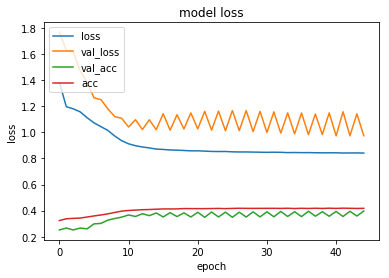

1.0627548353680187


W0809 14:07:59.922684 140493814896512 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0809 14:07:59.950210 140493814896512 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/45
800/800 [==============================] - 14s 18ms/step - loss: 1.3840 - acc: 0.3260 - val_loss: 1.3276 - val_acc: 0.3413
Epoch 2/45
800/800 [==============================] - 13s 16ms/step - loss: 1.2031 - acc: 0.3382 - val_loss: 1.1997 - val_acc: 0.3461
Epoch 3/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1880 - acc: 0.3401 - val_loss: 1.2866 - val_acc: 0.3417
Epoch 4/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1542 - acc: 0.3452 - val_loss: 1.1409 - val_acc: 0.3529
Epoch 5/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0977 - acc: 0.3548 - val_loss: 1.1762 - val_acc: 0.3551
Epoch 6/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0668 - acc: 0.3618 - val_loss: 1.0981 - val_acc: 0.3575
Epoch 7/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0493 - acc: 0.3669 - val_loss: 1.1452 - val_acc: 0.3598
Epoch 8/45
800/800 [==============================] - 13s 16ms

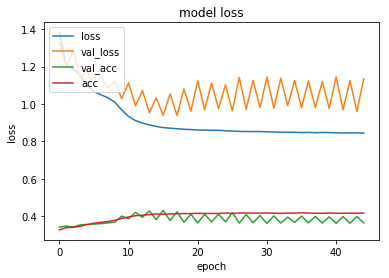

1.0500112825774857


W0809 14:18:43.180526 140493814896512 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/45
800/800 [==============================] - 14s 18ms/step - loss: 1.3865 - acc: 0.3231 - val_loss: 1.1910 - val_acc: 0.3510
Epoch 2/45
800/800 [==============================] - 13s 16ms/step - loss: 1.2088 - acc: 0.3338 - val_loss: 1.2789 - val_acc: 0.3428
Epoch 3/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1911 - acc: 0.3377 - val_loss: 1.1656 - val_acc: 0.3555
Epoch 4/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1597 - acc: 0.3431 - val_loss: 1.1949 - val_acc: 0.3627
Epoch 5/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1139 - acc: 0.3527 - val_loss: 1.0923 - val_acc: 0.3649
Epoch 6/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0779 - acc: 0.3590 - val_loss: 1.1342 - val_acc: 0.3676
Epoch 7/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0594 - acc: 0.3648 - val_loss: 1.0636 - val_acc: 0.3654
Epoch 8/45
800/800 [==============================] - 13s 16ms

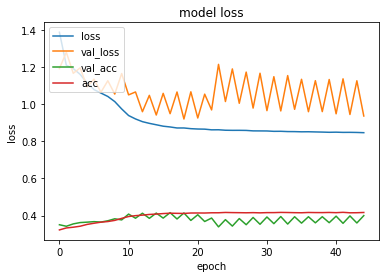

1.0253555899340536


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/45
800/800 [==============================] - 15s 18ms/step - loss: 1.4409 - acc: 0.3222 - val_loss: 1.3254 - val_acc: 0.3306
Epoch 2/45
800/800 [==============================] - 13s 16ms/step - loss: 1.2142 - acc: 0.3370 - val_loss: 1.1618 - val_acc: 0.3463
Epoch 3/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1967 - acc: 0.3400 - val_loss: 1.3150 - val_acc: 0.3360
Epoch 4/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1747 - acc: 0.3436 - val_loss: 1.1322 - val_acc: 0.3501
Epoch 5/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1306 - acc: 0.3499 - val_loss: 1.2203 - val_acc: 0.3537
Epoch 6/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0839 - acc: 0.3593 - val_loss: 1.0649 - val_acc: 0.3559
Epoch 7/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0587 - acc: 0.3631 - val_loss: 1.1630 - val_acc: 0.3643
Epoch 8/45
800/800 [==============================] - 13s 16ms

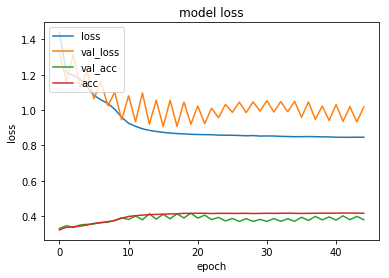

0.9705494719434162


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


Epoch 1/45
800/800 [==============================] - 15s 19ms/step - loss: 1.3964 - acc: 0.3269 - val_loss: 1.1586 - val_acc: 0.3516
Epoch 2/45
800/800 [==============================] - 13s 16ms/step - loss: 1.2032 - acc: 0.3369 - val_loss: 1.3120 - val_acc: 0.3378
Epoch 3/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1825 - acc: 0.3409 - val_loss: 1.1339 - val_acc: 0.3486
Epoch 4/45
800/800 [==============================] - 13s 16ms/step - loss: 1.1429 - acc: 0.3471 - val_loss: 1.2381 - val_acc: 0.3546
Epoch 5/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0962 - acc: 0.3570 - val_loss: 1.0671 - val_acc: 0.3499
Epoch 6/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0691 - acc: 0.3637 - val_loss: 1.1686 - val_acc: 0.3641
Epoch 7/45
800/800 [==============================] - 13s 16ms/step - loss: 1.0510 - acc: 0.3675 - val_loss: 1.0373 - val_acc: 0.3574
Epoch 8/45
800/800 [==============================] - 13s 16ms

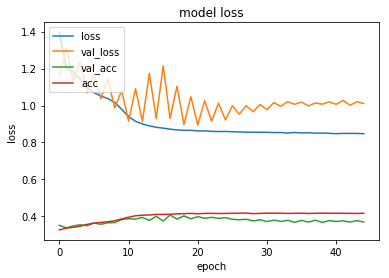

1.0160026093345884


In [0]:
generator=data_gen()
val_generator=data_gen_val()
test_generator=data_gen_test()
batch_size=100
schedular_unet=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

check_point=ModelCheckpoint('/content/drive/My Drive/comp9417-project/Neural Network/RS.hdf5',monitor='val_loss',verbose=0,save_best_only=True)

mse_list=[]
for i in range(len(train_files)):
    model=rs.movie_model()
    model.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])

    train_original_data=pickle.load(open(train_files[i],mode='rb'))
    np.array(train_original_data)
    train_rating=train_original_data['rating']
    train_original_data=train_original_data.drop(['rating'],axis=1)
    train_data=np.array(train_original_data)

#     np.random.shuffle(train_data)
    test_original_data=pickle.load(open(test_files[i],mode='rb'))
    test_rating=test_original_data['rating']
    test_original_data=test_original_data.drop(['rating'],axis=1)
    test_data=np.array(test_original_data)

    history=model.fit_generator(generator=generator.get_batches(train_data,train_rating,batch_size),validation_data=val_generator.get_batches(test_data,test_rating,batch_size),validation_steps=100,steps_per_epoch=(len(train_x)//batch_size),epochs=45)
    plt_hist(history)
    results=model.predict(next(test_generator.get_batches(test_data,len(test_data))))
    MSE=mean_squared_error(test_rating,results)
    print(MSE)
    mse_list.append(MSE)

In [0]:
mse_list

[1.0627548353680187,
 1.0500112825774857,
 1.0253555899340536,
 0.9705494719434162,
 1.0160026093345884]

Recommend movies to specific user


In [0]:
def predict_movie_for_user(userid,top_k):
    x=create_predict_data(userid)
    predict=model.predict(x)
    scores=sorted(predict[-top_k:],reverse=True)
    top_k_movie=list(reversed(predict.reshape(predict.shape[0]).argsort()[-top_k:]))
    top_k_movie_id=x['movie_id_input'][top_k_movie]
    movie_id=[i[0] for i in top_k_movie_id]
    movie_score=[i[0] for i in scores]
    movie_titles=[]
    for i in movie_id:
        movie_titles.append(movieId_title_dict[i])

    print('Recommanding top {} movies to user {}'.format(top_k,userid))
    print('*'*100)

    for idx in range(len(movie_titles)):
        title=movie_titles[idx]
        score=movie_score[idx]
        id=movie_id[idx]
        print('score：%.2f,   movie ID：%s,   movie name: %s' % (score, id,title))
    print('*'*100)
  

In [0]:
def create_predict_data(user_data):
    user_watched_movies=data[data['userId']==user_data]['movieId'].tolist()
    user_unwatched_movies=item_df['movieId'][user_watched_movies].tolist()
    movie_data=np.array(item_df.loc[item_df['movieId'][user_unwatched_movies]])
    size=len(user_watched_movies)
    
    user_data=np.array([user_df.values[user_data-1]]*(size))
    input_user_id_data=np.reshape(user_data.take(0,1),[size,1])
    input_user_gender_data=np.reshape(user_data.take(1,1),[size,1])
    input_user_age_data=np.reshape(user_data.take(2,1),[size,1])
    input_user_job_data=np.reshape(user_data.take(3,1),[size,1])
    
    input_movie_id_data=np.reshape(movie_data.take(0,1),[size,1])

    input_movie_type_data=np.zeros([size,movie_categories_max-1])
    for i in range(size):
        input_movie_type_data[i]=movie_data.take(2,1)[i]

    input_movie_title_data=np.zeros([size,sentences_size])
    for i in range(size):
        input_movie_title_data[i]=movie_data.take(1,1)[i]
    x={'movie_id_input': input_movie_id_data, 'movie_type_input':input_movie_type_data,
  'movie_title_input':input_movie_title_data,'user_id_intput':input_user_id_data,
  'user_age_intput':input_user_age_data,'user_gender_intput':input_user_gender_data,
   'user_job_input':input_user_job_data}
    return x 

In [0]:
model.compile(optimizer='sgd',loss='mean_squared_error',metrics=['accuracy'])
generator=data_gen()
val_generator=data_gen_val()
test_generator=data_gen_test()
batch_size=100
# model.fit_generator(generator=generator.get_batches(train_data,train_rating,batch_size),validation_data=val_generator.get_batches(test_data,test_rating,batch_size),validation_steps=100,steps_per_epoch=(len(train_x)//batch_size),epochs=50,callbacks=[schedular_unet])
# results=model.predict(next(test_generator.get_batches(test_data,len(test_data))))
history=model.fit_generator(generator=generator.get_batches(train_x,train_y,batch_size),validation_data=generator.get_batches(test_x,test_y,batch_size),validation_steps=100,steps_per_epoch=len(train_x)/batch_size, epochs=10)


W0810 04:44:57.044774 139669736257408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0810 04:44:57.691681 139669736257408 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
800/800 [==============================] - 18s 23ms/step - loss: 1.4401 - acc: 0.3045 - val_loss: 1.2586 - val_acc: 0.3289
Epoch 2/10
800/800 [==============================] - 12s 15ms/step - loss: 1.2520 - acc: 0.3249 - val_loss: 1.2232 - val_acc: 0.3140
Epoch 3/10
800/800 [==============================] - 12s 15ms/step - loss: 1.2099 - acc: 0.3350 - val_loss: 1.1824 - val_acc: 0.3524
Epoch 4/10
800/800 [==============================] - 12s 14ms/step - loss: 1.1388 - acc: 0.3503 - val_loss: 1.0788 - val_acc: 0.3573
Epoch 5/10
800/800 [==============================] - 12s 14ms/step - loss: 1.0402 - acc: 0.3713 - val_loss: 0.9976 - val_acc: 0.3865
Epoch 6/10
800/800 [==============================] - 12s 15ms/step - loss: 0.9677 - acc: 0.3880 - val_loss: 0.9258 - val_acc: 0.3844
Epoch 7/10
800/800 [==============================] - 12s 14ms/step - loss: 0.9323 - acc: 0.3955 - val_loss: 0.9285 - val_acc: 0.4032
Epoch 8/10
800/800 [==============================] - 12s 15ms

In [0]:
predict_movie_for_user(7,10)

Recommanding top 10 movies to user 7
****************************************************************************************************
score：4.69,   movie ID：408,   movie name: Close Shave, A (1995)
score：4.26,   movie ID：169,   movie name: Wrong Trousers, The (1993)
score：4.13,   movie ID：12,   movie name: Usual Suspects, The (1995)
score：3.87,   movie ID：483,   movie name: Casablanca (1942)
score：3.85,   movie ID：50,   movie name: Star Wars (1977)
score：3.44,   movie ID：603,   movie name: Rear Window (1954)
score：3.42,   movie ID：134,   movie name: Citizen Kane (1941)
score：3.37,   movie ID：178,   movie name: 12 Angry Men (1957)
score：2.91,   movie ID：657,   movie name: Manchurian Candidate, The (1962)
score：2.87,   movie ID：272,   movie name: Good Will Hunting (1997)
****************************************************************************************************
